# Example of usage of AdaBKB

In [1]:
import numpy as np

from adabkb import AdaBKB
from adabkb.options import OptimizerOptions
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState

## Target function: Branin

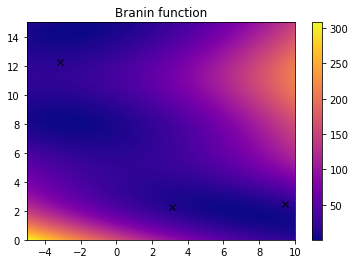

In [2]:
from benchmark_functions import Branin

def plot_fun(x1, x2, fun):
    X = np.zeros((x1.shape[0], x2.shape[0]))
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            X[i,j] = fun([x1[i], x2[j]])
    fig, ax = plt.subplots()
    ax.set_title("Branin function")
    c = ax.imshow(X, cmap='plasma', vmin=X.min(), vmax = X.max(),
              extent=[x1.min(), x1.max(), x2.min(), x2.max()],
              interpolation='gaussian', origin='lower', aspect='auto')
    gmins = np.array(fun.global_min[0]).reshape(-1, 2)
    ax.plot(gmins[:, 0], gmins[:, 1], 'x', c='black', label="real optimizer")
    fig.colorbar(c, ax=ax)
    return fig, ax
fun = Branin((0.0, RandomState(42)))
x1 = np.linspace(-5.0, 10.0, 400).reshape(-1)
x2 = np.linspace(0.0, 15.0, 400).reshape(-1)
fig, ax = plot_fun(x1, x2, fun)

In [3]:
def is_in(x, lst):
    for y in lst:
        if np.all(x == y):
            return True
    return False

sigma = 3.0
lam = 1e-5
N = 2
v1 = 2 * np.sqrt(N)
rho = N**(-1/2)
gfun = lambda x: (1/sigma) * x 
options = OptimizerOptions(gfun, v_1=v1, rho=rho, lam=lam, fnorm=1.0, noise_var=lam**2, verbose=True)
opt = AdaBKB(RBF(sigma), options)
T = 200
t = 0
opt.initialize(N, h_max = 10)
#print("root: ",fun.search_space.mean(axis=1))
eval_x = []
root = fun.search_space.mean(axis=1)
ax.plot(root[0], root[1], 'o', c='red', label="root")
while t <= T:
    xt, ind = opt.step()
    if not is_in(xt, eval_x):
        eval_x.append(xt)
    yt = -fun(xt)
    opt.update_model(ind, yt)
    t+=1
print("[--] Best x: {} => {}".format(opt.current_best[0].x, fun(opt.current_best[0].x)))
xb = opt.current_best[0].x
yb = fun(xb)
eval_x = np.array(eval_x).reshape(-1,2)



[--] update completed in 0.002203 seconds.
[--] update completed in 0.002753 seconds.
[--] update completed in 0.004356 seconds.
[--] update completed in 0.003353 seconds.
[--] update completed in 0.010448 seconds.
[--] update completed in 0.005369 seconds.
[--] update completed in 0.005809 seconds.
[--] update completed in 0.003090 seconds.
[--] update completed in 0.011103 seconds.
[--] update completed in 0.014999 seconds.
[--] update completed in 0.010188 seconds.
[--] update completed in 0.003708 seconds.
[--] update completed in 0.003388 seconds.
[--] update completed in 0.006250 seconds.
[--] update completed in 0.003475 seconds.
[--] update completed in 0.012096 seconds.
[--] update completed in 0.003579 seconds.
[--] update completed in 0.008678 seconds.
[--] update completed in 0.003532 seconds.
[--] update completed in 0.003313 seconds.
[--] update completed in 0.010270 seconds.
[--] update completed in 0.004558 seconds.
[--] update completed in 0.008476 seconds.
[--] update

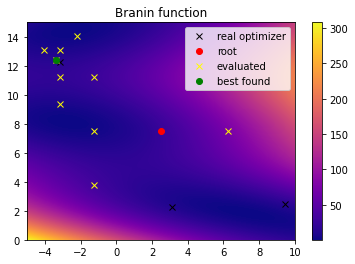

In [4]:
ax.plot(eval_x[:,0], eval_x[:, 1], 'x', color="yellow", label="evaluated")
ax.plot(xb[0], xb[1], 'o', color="green", label="best found")
ax.legend(loc="upper right")
fig

In [5]:
from batchbkb.bkb_lib import BKB


size = [10, 50, 100, 200]


